# Building Fast Queries on a CSV

In this notebook, we'll be looking at inventory data for a laptop store. Throughout the notebook, we'll be building an "Inventory()" class to efficiently query our dataset. Specific queries which we will implement will allow the store employees to:

- efficiently look up laptop data given its ID
- ensure there is always a way for customers to spend all of their promotion credit
- assist customers in finding a laptop within their budget

After introducing a few different algorithms for solving each of the problems above, we'll also perform a time/space - complexity analysis for each algorithm. Using this information, we can determine, for each query above, which algorithm is most optimal for this laptop store.

# Summary

After analyzing a few different algorithms, we concluded that:

- ID lookups could be performed efficiently by storing storing a dictionary, mapping the laptop ID to its data. While this costs memory, it allows ID lookups to be performed in O(1) time (since dictionaries in python are implemented using hash-tables). While we pay the cost for this by storing an additional sorted memory, we still conclude to use this approach since storing an extra inventory is not too big of an issue, and the alternative is each lookup taking O(N) time.

- To ensure customers could use all of their promotion points, we found an algorithm which queries the dataset to see if either 
    - a single laptop can be purchased using all promotion dollars
    - two laptops can be purchased using all promotion dollars
    
    We decided to store prices as a set. This costs some memory, but allows us to check the first bullet point above in O(1) time, and the second in O(N) time. We decide on this method since the alternative costs quadratic time! 


- Finally, we found a laptop closest to, but within a customer's price range by storing an extra version of the inventory, sorted by price. This allows us to implement a binary search algorithm to find the laptop in O(log N) time. Unforuntately, this results in higher memory usage and a slightly longer intialization time for our Inventory() class. However, employees perform customer budget checks frequently, so this method wins in the long run. 

By the end of this notebook, we have the following time efficient inventory class for laptop employees to use for efficiently querying their database:

In [ ]:
class TimeEfficientInventory():
    #____________________________________________
    #initializes attributes: 
    # self.header, self.rows, self.id_to_row, self.prices, self.rows_by_price 
    def __init__(self,csv_filename):
        #read file
        with open(csv_filename, encoding = 'utf8') as file:
            data = list(csv.reader(file))
        #_____________
        #assign self.header
        header = data[0]
        self.header = header
        #___________
        #assign self.rows
        rows = data[1:] 
        self.rows = rows
        #_______________________________
        #convert price column to integer
        for row in rows:                                    #O(N)
            row[-1] = int(row[-1])                              #O(1)    
        #______________________           
        # assign self.id_to_row
        self.id_to_row = {}
        for row in rows:                                    #O(N)
            laptop_id = row[0]                                  #O(1)
            self.id_to_row[laptop_id] = row                     #O(1)
        #__________________________________________
        # assign self.prices, the set of all prices
        self.prices = set()
        for row in rows:                                    #O(N)
            self.prices.add(row[-1])                            #O(1)
        #_________________________________________
        # helper function which eats a row, 
        # and returns its price - used for self.rows_by_price
        def row_price(row):
            return row[-1]
        
        # assign self.rows_by_price, 
        # a sorted version of rows
        self.rows_by_price = sorted(rows, key = row_price)      #O(N log N)
        
    #______________________________________
    #______________________________________
    #given laptop_id, returns corresponding
    #row using dictionary self.id_to_row
    def get_laptop_from_id_fast(self, laptop_id):
        if laptop_id in self.id_to_row:                     #O(1) lookup time, since dictionary uses hash table
            return self.id_to_row[laptop_id]        
        return None
    
    #______________________________________
    #______________________________________
    #same function as check_promotion_dollars
    #uses the set of all prices self.prices
    def check_promotion_dollars_fast(self, dollars):
        if dollars in self.prices:                          #O(1)
            return True
        for row in self.rows:                               #O(N)
            if (dollars - row[-1]) in self.prices:              #O(1)
                return True  
        return False
    
    #_________________________________
    # uses self.rows_by_price to find first laptop outside
    # budget range in O(log N) time using a binary search
    def find_first_laptop_more_expensive(self, target_price):
        #initialize possible index range  
        lower_bound = 0
        upper_bound = len(self.rows_by_price) - 1          

        while lower_bound < upper_bound:                    #O(log N) <--- number of possible indices cut in half
            #guess item at midpoint of index range                          each iteration 
            guess = (upper_bound + lower_bound)//2          
            price = self.rows_by_price[guess][-1]
            #if guess was too big, decrease upper range
            if price > target_price:
                upper_bound = guess
            #if guess was too small, increase lower range
            else:
                lower_bound = guess + 1
           
           
        price = self.rows_by_price[lower_bound][-1]
        # if final guess is wrong, return -1 --> customer can afford all laptops
        if price <= target_price:
            return -1
        return lower_bound

# About the Data

The dataset used in this notebook was originally found [here](https://www.kaggle.com/ionaskel/laptop-prices). It contains information regarding the laptop inventory of a laptop store. Columns of the dataset are summarized in the following table.

| Column name | Description |
| --- | --- |
| ID | A unique identifier for the laptop. |
| Company | The name of the company that produces the laptop. |
| Product | The name of the laptop. |
| TypeName | The type of laptop. |
| Inches | The size of the screen in inches. |
| ScreenResolution | The resolution of the screen. |
| CPU | The laptop CPU. |
| RAM | The amount of RAM in the laptop. |
| Memory | The size of the hard drive. |
| GPU | The graphics card name. |
| OpSys | The name of the operating system. |
| Weight | The laptop weight. |
| Price | The price of the laptop. |

# Reading in the Dataset

We'll begin by using a context manager to open the laptop dataset.

In [1]:
import csv 
with open('laptops.csv', encoding = 'utf8') as file:
    data = list(csv.reader(file))           #read in data as list of lists
    header = data[0]                        #separate first item (header)
    rows = data[1:]                         #store remaining data

Let's take a look at the first few rows.

In [2]:
import pprint 
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(header)
pp.pprint(rows[0:5])

[   'Id',
    'Company',
    'Product',
    'TypeName',
    'Inches',
    'ScreenResolution',
    'Cpu',
    'Ram',
    'Memory',
    'Gpu',
    'OpSys',
    'Weight',
    'Price']
[   [   '6571244',
        'Apple',
        'MacBook Pro',
        'Ultrabook',
        '13.3',
        'IPS Panel Retina Display 2560x1600',
        'Intel Core i5 2.3GHz',
        '8GB',
        '128GB SSD',
        'Intel Iris Plus Graphics 640',
        'macOS',
        '1.37kg',
        '1339'],
    [   '7287764',
        'Apple',
        'Macbook Air',
        'Ultrabook',
        '13.3',
        '1440x900',
        'Intel Core i5 1.8GHz',
        '8GB',
        '128GB Flash Storage',
        'Intel HD Graphics 6000',
        'macOS',
        '1.34kg',
        '898'],
    [   '3362737',
        'HP',
        '250 G6',
        'Notebook',
        '15.6',
        'Full HD 1920x1080',
        'Intel Core i5 7200U 2.5GHz',
        '8GB',
        '256GB SSD',
        'Intel HD Graphics 620',
        'No OS'

# Building an Inventory Class

Let's create our first iteration of the Inventory() class with the same functionality as above. Namely, we create an Inventory() class which 
- accepts a csv_filename
- initializes with attributes "self.header" and "self.rows" as above 


In [3]:
class Inventory():
    def __init__(self,csv_filename):
        with open(csv_filename, encoding = 'utf8') as file:
            data = list(csv.reader(file))
        header = data[0]
        rows = data[1:]
        
        self.header = header
        for row in rows:
            row[-1] = int(row[-1])
        self.rows = rows

We can check the functionality of this class by creating an instance, and looking at its header attribute. 

In [4]:
laptops = Inventory('laptops.csv')

In [5]:
print(laptops.header)
print(len(laptops.rows))

['Id', 'Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'Price']
1303


## Two ID Search Methods: Time and Space Complexity Analysis

Recall that our first task is to implement a method into the inventory class which, given a laptop ID, finds the corresponding row. Let's begin with a naive approach at solving this problem.

For future problems, we want to sort by price. Currently, however, the price is a string. Hence, we'll also convert the price column to integer upon initialization.

In [6]:
class Inventory():
    #____________________________________________
    #initializes attributes self.header, self.rows
    def __init__(self,csv_filename):
        #read file
        with open(csv_filename, encoding = 'utf8') as file:
            data = list(csv.reader(file))
        #_____________
        #assign header
        header = data[0]
        self.header = header
        #___________
        #assign rows
        rows = data[1:] 
        self.rows = rows
        #_______________________________
        #convert price column to integer
        for row in rows:                                        #O(N)
            row[-1] = int(row[-1])                              #O(1)
        
    #______________________________________
    #______________________________________
    #given laptop_id, loops through rows, 
    #returns row with given laptop_id
    def get_laptop_from_id(self, laptop_id):
        for row in self.rows:                                   #O(N)
            if row[0] == laptop_id:                             #O(1)
                return row
        return None            #if no laptop found, return None
        

Note that the self.get_laptop_from_id() method loops through all the rows, and hence has time complxity O(N), where N is the number of rows in the dataset. Similarly, now the intialization loops through the rows, and has time complexity O(N). Let's check this on a few ID's.

In [7]:
laptops = Inventory('laptops.csv')
print(laptops.get_laptop_from_id('3362737'))
print(laptops.get_laptop_from_id('3362736'))

['3362737', 'HP', '250 G6', 'Notebook', '15.6', 'Full HD 1920x1080', 'Intel Core i5 7200U 2.5GHz', '8GB', '256GB SSD', 'Intel HD Graphics 620', 'No OS', '1.86kg', 575]
None


We can see that if laptop_id is in the dataset, it returns the corresponding row, and when laptop_id is not, our method returns "None".

Since employees will likely query for laptop_id's frequently, it may be beneficial to store each row in a dictionary where the key is the appropriate laptop_id. This will cause some extra time for initialization, as well as some extra memory cost. However, using the dictionary, laptop_id lookups can be performed in O(1) time.

We can implement this solution by amending the above class as shown below.

In [50]:
class Inventory():
    #____________________________________________
    #initializes attributes: 
    # self.header, self.rows, self.id_to_row
    def __init__(self,csv_filename):
        #read file
        with open(csv_filename, encoding = 'utf8') as file:
            data = list(csv.reader(file))
        #_____________
        #assign header
        header = data[0]
        self.header = header
        #___________
        #assign rows
        rows = data[1:] 
        self.rows = rows
        #_______________________________
        #convert price column to integer
        for row in rows:                                    #O(N)
            row[-1] = int(row[-1])                              #O(1)    
        #______________________           
        # assign self.id_to_row
        self.id_to_row = {}
        for row in rows:                                    #O(N)
            laptop_id = row[0]                                  #O(1)
            self.id_to_row[laptop_id] = row                     #O(1)
        
    #______________________________________
    #______________________________________
    #given laptop_id, loops through rows, 
    #returns row with given laptop_id
    def get_laptop_from_id(self, laptop_id):
        for row in self.rows:                               #O(N)
            if row[0] == laptop_id:                             #O(1)
                return row
        return None            #if no laptop found, return None

    #______________________________________
    #______________________________________
    #given laptop_id, returns corresponding
    #row using dictionary self.id_to_row
    def get_laptop_from_id_fast(self, laptop_id):
        if laptop_id in self.id_to_row:                     #O(1) lookup time, since dictionary uses hash table
            return self.id_to_row[laptop_id]        
        return None
    

Initialization still requires O(N) time, but now using the fast function, we can do laptop_id lookups in constant time. Let's test the method out on a few ID's. 

In [9]:
laptops = Inventory('laptops.csv')

print(laptops.get_laptop_from_id_fast('3362737'))

print(laptops.get_laptop_from_id_fast('3362736'))

['3362737', 'HP', '250 G6', 'Notebook', '15.6', 'Full HD 1920x1080', 'Intel Core i5 7200U 2.5GHz', '8GB', '256GB SSD', 'Intel HD Graphics 620', 'No OS', '1.86kg', 575]
None


To conclude this section, let's verify the theoretical time complexity of each method. 

In this code cell, we setup the experiment to study the time complexity. Note that the id's are all integers bewteen 1000000 and 9999999.

In [51]:
import time,random

N = 1303                    #number of rows in our dataset
stepsize = 5                #time resolution 
num_trials = 50             #randomness resolution

time_complexity_no_dict = []        #empty lists for plotting data
time_complexity_dict = []
data_size = []

while N > 0:                        
    ids = [str(random.randint(1000000,9999999)) for _ in range(num_trials)]
    laptops = Inventory('laptops.csv')
    laptops.rows = laptops.rows[0:N]        #make laptop.rows a length of N

    total_time_no_dict = 0                  
    for id in ids:
        start = time.time()
        laptops.get_laptop_from_id(id)
        end = time.time()
        total_time_no_dict += (end - start)     #total time to call get_laptop_from_id() (num_trials) times

    mean_time_no_dict = total_time_no_dict/num_trials
    time_complexity_no_dict.append(mean_time_no_dict)   #append means to dataset
    
    total_time_dict = 0
    for id in ids:
        start = time.time()
        laptops.get_laptop_from_id_fast(id)
        end = time.time()
        total_time_dict += (end - start)           #total time to call get_laptop_from_id_fast() num_trials_times

    mean_time_dict = total_time_dict/num_trials
    time_complexity_dict.append(mean_time_dict)

    data_size.append(N)
    N = N - stepsize        #reduce N

Let's plot our results. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(135, 3.5e-05, 'O(N)')

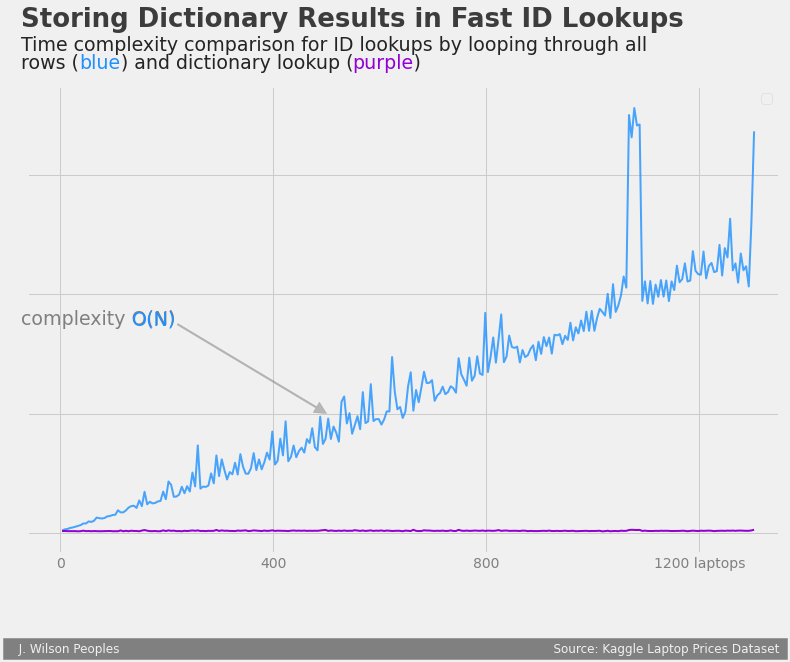

In [90]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
#___________________________________________________________
#Initial Plot
fig,ax = plt.subplots(figsize = (12,8))
ax.plot(data_size,time_complexity_no_dict, linewidth = 2, alpha = .8, color = 'dodgerblue')
ax.plot(data_size,time_complexity_dict, linewidth = 2, color = 'darkviolet')
#____________________________________________________________
#Format grid, ticks, etc
ax.legend()
ax.set_xticks([0,400,800,1200])
ax.set_xticklabels(['0','400','800','1200 laptops'])
ax.set_yticks([0,.000020,.000040,.000060])
ax.set_xlim(right = 1350)
ax.set_yticklabels([])
ax.set_ylim(top = .000075)
ax.tick_params(colors = 'grey', which = 'both')
#___________________________________________________________
#create title,subtitle,signature bar
ax.text(-75,.000085, 'Storing Dictionary Results in Fast ID Lookups', weight = 'bold', size = 26, alpha = .75)
ax.text(-75,.000081, 'Time complexity comparison for ID lookups by looping through all', size = 19, alpha = .85)
ax.text(-75,.000078, 'rows (       ) and dictionary lookup (          ) ', size = 19, alpha = .85)
ax.text(x = -100, y = -.00002,
    s = '   J. Wilson Peoples                                                                                                                Source: Kaggle Laptop Prices Dataset ',
    fontsize = 12, color = '#f0f0f0', backgroundcolor = 'grey')
#_____________________________________________________________
#on figure annotations
ax.text(x = 35, y = .000078, s ='blue', color = 'dodgerblue', size = 19)
ax.text(x = 549, y = .000078, s ='purple', color = 'darkviolet', size = 19)

ax.annotate("", xy=(500, .00002), xytext=(220,.000035),
            arrowprops=dict(width = 1.5, color = 'grey',alpha = .5))

ax.text(x = -75, y = .000035, s ='complexity O(N)', color = 'grey', size = 19)
ax.text(x = 135, y = .000035, s ='O(N)', color = 'dodgerblue', size = 19)



We see that the experimental time complexity coincide with our theoretical deductions. We conclude that implementing the self.id_to_row dictionary will save the laptop store employees quite a bit of time.

## Maximizing Promotion Dollars Spent

Consider the following scenario. Occasionally, the laptop store holds a promotion where giftcards are given out to a select few customers. These can be used __one time only__ to purchase __up to two__ laptops. The store owner wants to ensure, before issuing a promotion, that customers will at least have the opportunity to spend all of the money on their giftcard. 

A natural way to solve this issue is to create a method which, given a value __dollars__, checks whether one or two laptops whose price(s) sum to exactly __dollars__.  Then, before issuing a promotion, this method can be called to see if exactly __dollars__ can be spent buying up to two laptops. 

Let's first solve this in a brute force way, looping through each row twice. 

In [13]:
class Inventory():
    #____________________________________________
    #initializes attributes: 
    # self.header, self.rows, self.id_to_row
    def __init__(self,csv_filename):
        #read file
        with open(csv_filename, encoding = 'utf8') as file:
            data = list(csv.reader(file))
        #_____________
        #assign header
        header = data[0]
        self.header = header
        #___________
        #assign rows
        rows = data[1:] 
        self.rows = rows
        #_______________________________
        #convert price column to integer
        for row in rows:                                    #O(N)
            row[-1] = int(row[-1])                              #O(1)    
        #______________________           
        # assign self.id_to_row
        self.id_to_row = {}
        for row in rows:                                    #O(N)
            laptop_id = row[0]                                  #O(1)
            self.id_to_row[laptop_id] = row                     #O(1)
        
    #______________________________________
    #______________________________________
    #given laptop_id, loops through rows, 
    #returns row with given laptop_id
    def get_laptop_from_id(self, laptop_id):
        for row in self.rows:                               #O(N)
            if row[0] == laptop_id:                             #O(1)
                return row
        return None            #if no laptop found, return None

    #______________________________________
    #______________________________________
    #given laptop_id, returns corresponding
    #row using dictionary self.id_to_row
    def get_laptop_from_id_fast(self, laptop_id):
        if laptop_id in self.id_to_row:                     #O(1) lookup time, since dictionary uses hash table
            return self.id_to_row[laptop_id]        
        return None
    
    #______________________________________
    #______________________________________
    #given dollars, returns True or False
    #True: if exactly (dollars) can be spent
    # purchasing up to two laptops
    #False: otherwise
    def check_promotion_dollars(self, dollars):
        #see if any laptop costs exactly dollars
        for row in self.rows:                               #O(N)         
            if row[-1] == dollars:                              #O(1)
                return True
        #if not, check if two laptops have prices adding to dollars
        for row_1 in self.rows:                             #O(N)
            for row_2 in self.rows:                             #O(N) <---- total of O(N^2)
                if (row_1[-1] + row_2[-1] == dollars):
                    return True
        #if neither case above, return false
        return False

We'll confirm our new method words by calling it for some prices.

In [14]:
laptops = Inventory('laptops.csv')
print(laptops.check_promotion_dollars(1000))
print(laptops.check_promotion_dollars(442))


True
False


Note that from the comments above, the newly defined method has time complexity O(N^2), which is not desirable.

If we instead store all the prices as a set during initialization (which takes O(N) time), then checking to see if any laptop costs exactly __dollars__ can be done in O(1) time. Moreover, we can see if any two laptops have prices summing to __dollars__ in the following way:

- Loop through all the rows, and let __price__ be the price of that row.
- If we buy an item for price __price__, we have __dollars__ - __price__ left over.
- Hence, we only need to check if __dollars__ - __price__ is in the set of all prices.

Taking the above steps should speed the promotion checking method up to O(N) time. We implement these ideas below. 

In [15]:
class Inventory():
    #____________________________________________
    #initializes attributes: 
    # self.header, self.rows, self.id_to_row, self.prices 
    def __init__(self,csv_filename):
        #read file
        with open(csv_filename, encoding = 'utf8') as file:
            data = list(csv.reader(file))
        #_____________
        #assign header
        header = data[0]
        self.header = header
        #___________
        #assign rows
        rows = data[1:] 
        self.rows = rows
        #_______________________________
        #convert price column to integer
        for row in rows:                                    #O(N)
            row[-1] = int(row[-1])                              #O(1)    
        #______________________           
        # assign self.id_to_row
        self.id_to_row = {}
        for row in rows:                                    #O(N)
            laptop_id = row[0]                                  #O(1)
            self.id_to_row[laptop_id] = row                     #O(1)

        # assign self.prices, the set of all prices
        self.prices = set()
        for row in rows:                                    #O(N)
            self.prices.add(row[-1])                            #O(1)
        
    #______________________________________
    #______________________________________
    #given laptop_id, loops through rows, 
    #returns row with given laptop_id
    def get_laptop_from_id(self, laptop_id):
        for row in self.rows:                               #O(N)
            if row[0] == laptop_id:                             #O(1)
                return row
        return None            #if no laptop found, return None

    #______________________________________
    #______________________________________
    #given laptop_id, returns corresponding
    #row using dictionary self.id_to_row
    def get_laptop_from_id_fast(self, laptop_id):
        if laptop_id in self.id_to_row:                     #O(1) lookup time, since dictionary uses hash table
            return self.id_to_row[laptop_id]        
        return None
    
    #______________________________________
    #______________________________________
    #given dollars, returns True or False
    #True: if exactly (dollars) can be spent
    # purchasing up to two laptops
    #False: otherwise
    def check_promotion_dollars(self, dollars):
        #see if any laptop costs exactly dollars
        for row in self.rows:                               #O(N)         
            if row[-1] == dollars:                              #O(1)
                return True
        #if not, check if two laptops have prices adding to dollars
        for row_1 in self.rows:                             #O(N)
            for row_2 in self.rows:                             #O(N) <---- total of O(N^2)
                if (row_1[-1] + row_2[-1] == dollars):
                    return True
        #if neither case above, return false
        return False
    #______________________________________
    #______________________________________
    #same function as check_promotion_dollars
    #uses the set of all prices self.prices
    def check_promotion_dollars_fast(self, dollars):
        if dollars in self.prices:                          #O(1)
            return True
        for row in self.rows:                               #O(N)
            if (dollars - row[-1]) in self.prices:              #O(1)
                return True  
        return False

Again, we can test our newly defined method on the same rows as before. 

In [16]:
laptops = Inventory('laptops.csv')
print(laptops.check_promotion_dollars_fast(1000))
print(laptops.check_promotion_dollars_fast(442))

True
False


Let's again confirm our theotical deductions regarding runtime with an experiment. 

In [17]:
import time,random

N = 1303                    #number of rows in our dataset
stepsize = 10              #time resolution 
num_trials = 100            #randomness resolution

time_complexity_no_set = []        #empty lists for plotting data
time_complexity_set = []
data_size = []

while N > 0:                        
    dollars_list = [random.randint(100,5000) for _ in range(num_trials)]
    laptops = Inventory('laptops.csv')
    laptops.rows = laptops.rows[0:N]        #make laptop.rows a length of N

    total_time_no_set = 0                  
    for dollars in dollars_list:
        start = time.time()
        laptops.check_promotion_dollars(dollars)
        end = time.time()
        total_time_no_set += (end - start)     #total time to call get_laptop_from_id() (num_trials) times

    mean_time_no_set = total_time_no_set/num_trials
    time_complexity_no_set.append(mean_time_no_set)   #append means to dataset
    
    total_time_set = 0
    for dollars in dollars_list:
        start = time.time()
        laptops.check_promotion_dollars_fast(dollars)
        end = time.time()
        total_time_set += (end - start)           #total time to call get_laptop_from_id_fast() num_trials_times

    mean_time_set = total_time_set/num_trials
    time_complexity_set.append(mean_time_set)

    data_size.append(N)
    N = N - stepsize        #reduce N

Let's plot the results.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(945, 0.00915, 'green')

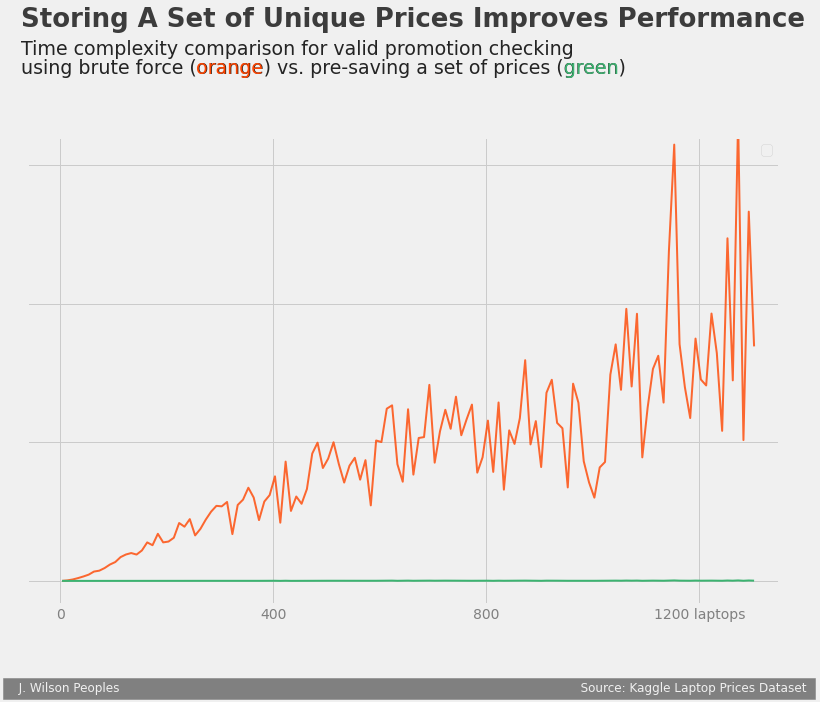

In [37]:
import matplotlib.pyplot as plt
#___________________________________________________________
#Initial Plot
fig,ax = plt.subplots(figsize = (12,8))
ax.plot(data_size,time_complexity_no_set, linewidth = 2, alpha = .8, color = 'orangered')
ax.plot(data_size,time_complexity_set, linewidth = 2, color = 'mediumseagreen')
#____________________________________________________________
#Format grid, ticks, etc
ax.legend()
ax.set_xticks([0,400,800,1200])
ax.set_xticklabels(['0','400','800','1200 laptops'])
ax.set_yticks([0,.0025,.005,.0075,.010])
ax.set_xlim(right = 1350)
ax.set_yticklabels([])
ax.set_ylim(top = .008)
ax.tick_params(colors = 'grey', which = 'both')
#___________________________________________________________
#create title,subtitle,signature bar
ax.text(-75,.0100, 'Storing A Set of Unique Prices Improves Performance ', weight = 'bold', size = 26, alpha = .75)
ax.text(-75,.0095, 'Time complexity comparison for valid promotion checking', size = 19, alpha = .85)
ax.text(-75,.00915, 'using brute force (orange) vs. pre-saving a set of prices (green) ', size = 19, alpha = .85)
ax.text(x = -100, y = -.002,
    s = '   J. Wilson Peoples                                                                                                                       Source: Kaggle Laptop Prices Dataset ',
    fontsize = 12, color = '#f0f0f0', backgroundcolor = 'grey')
#_____________________________________________________________
#on figure annotations
ax.text(x = 255, y = .00915, s ='orange', color = 'orangered', size = 19)
ax.text(x = 945, y = .00915, s ='green', color = 'mediumseagreen', size = 19)


In practice we see that both algorithms perform better than their worst case analysis. Nevertheless, the solution involving the set performs much faster. However, it does cost more memory to store the set of all prices. Overall, we choose the faster method since saving an extra set isn't too memory intensive.

## Finding Laptops Within Budget

For the final query, we want employees to be able to efficiently find a laptop which best fits the customer's budget. 

Our basic idea is as follows:
- Store an extra version of rows, sorted by price. 
- We can initialize this as an attribute __self.rows_by_price__. 
- With a sorted version of rows, we can use a binary search algorithm to find the most expensive laptop within a customer's budget.

To begin, let's add in the __self.rows_by_price__ attribute and make sure its working properly. 

In [38]:
class Inventory():
    #____________________________________________
    #initializes attributes: 
    # self.header, self.rows, self.id_to_row, self.prices, self.rows_by_price 
    def __init__(self,csv_filename):
        #read file
        with open(csv_filename, encoding = 'utf8') as file:
            data = list(csv.reader(file))
        #_____________
        #assign self.header
        header = data[0]
        self.header = header
        #___________
        #assign self.rows
        rows = data[1:] 
        self.rows = rows
        #_______________________________
        #convert price column to integer
        for row in rows:                                    #O(N)
            row[-1] = int(row[-1])                              #O(1)    
        #______________________           
        # assign self.id_to_row
        self.id_to_row = {}
        for row in rows:                                    #O(N)
            laptop_id = row[0]                                  #O(1)
            self.id_to_row[laptop_id] = row                     #O(1)
        #__________________________________________
        # assign self.prices, the set of all prices
        self.prices = set()
        for row in rows:                                    #O(N)
            self.prices.add(row[-1])                            #O(1)
        #_________________________________________
        # helper function which eats a row, 
        # and returns its price - used for self.rows_by_price
        def row_price(row):
            return row[-1]
        
        # assign self.rows_by_price, 
        # a sorted version of rows
        self.rows_by_price = sorted(rows, key = row_price)      #O(N log N)
        
        
    #______________________________________
    #______________________________________
    #given laptop_id, loops through rows, 
    #returns row with given laptop_id
    def get_laptop_from_id(self, laptop_id):
        for row in self.rows:                               #O(N)
            if row[0] == laptop_id:                             #O(1)
                return row
        return None            #if no laptop found, return None

    #______________________________________
    #______________________________________
    #given laptop_id, returns corresponding
    #row using dictionary self.id_to_row
    def get_laptop_from_id_fast(self, laptop_id):
        if laptop_id in self.id_to_row:                     #O(1) lookup time, since dictionary uses hash table
            return self.id_to_row[laptop_id]        
        return None
    
    #______________________________________
    #______________________________________
    #given dollars, returns True or False
    #True: if exactly (dollars) can be spent
    # purchasing up to two laptops
    #False: otherwise
    def check_promotion_dollars(self, dollars):
        #see if any laptop costs exactly dollars
        for row in self.rows:                               #O(N)         
            if row[-1] == dollars:                              #O(1)
                return True
        #if not, check if two laptops have prices adding to dollars
        for row_1 in self.rows:                             #O(N)
            for row_2 in self.rows:                             #O(N) <---- total of O(N^2)
                if (row_1[-1] + row_2[-1] == dollars):
                    return True
        #if neither case above, return false
        return False
    #______________________________________
    #______________________________________
    #same function as check_promotion_dollars
    #uses the set of all prices self.prices
    def check_promotion_dollars_fast(self, dollars):
        if dollars in self.prices:                          #O(1)
            return True
        for row in self.rows:                               #O(N)
            if (dollars - row[-1]) in self.prices:              #O(1)
                return True  
        return False

Let's make sure these values are properly sorted according to increasing price.

In [39]:
laptops = Inventory('laptops.csv')
for i in range(0,5):
    print(laptops.rows_by_price[i][-1])

174
191
196
199
199


We note that now during initialization, we call python's built in sorted() function to sort the rows by price. This is a bit of a [syntactic sugar](https://en.wikipedia.org/wiki/Syntactic_sugar#:~:text=In%20computer%20science%2C%20syntactic%20sugar,style%20that%20some%20may%20prefer), since this line of code actually takes O(N log N) time to run. However, this function uses the [timsort](https://en.wikipedia.org/wiki/Timsort#:~:text=Timsort%20is%20a%20hybrid%2C%20stable,in%20the%20Python%20programming%20language.) algorithm, which is considered one of the best sorting algorithms out there.

Now, we'll define a method which uses a binary search to find the first laptop outside of the customer's budget. 

In [2]:
class Inventory():
    #____________________________________________
    #initializes attributes: 
    # self.header, self.rows, self.id_to_row, self.prices, self.rows_by_price 
    def __init__(self,csv_filename):
        #read file
        with open(csv_filename, encoding = 'utf8') as file:
            data = list(csv.reader(file))
        #_____________
        #assign self.header
        header = data[0]
        self.header = header
        #___________
        #assign self.rows
        rows = data[1:] 
        self.rows = rows
        #_______________________________
        #convert price column to integer
        for row in rows:                                    #O(N)
            row[-1] = int(row[-1])                              #O(1)    
        #______________________           
        # assign self.id_to_row
        self.id_to_row = {}
        for row in rows:                                    #O(N)
            laptop_id = row[0]                                  #O(1)
            self.id_to_row[laptop_id] = row                     #O(1)
        #__________________________________________
        # assign self.prices, the set of all prices
        self.prices = set()
        for row in rows:                                    #O(N)
            self.prices.add(row[-1])                            #O(1)
        #_________________________________________
        # helper function which eats a row, 
        # and returns its price - used for self.rows_by_price
        def row_price(row):
            return row[-1]
        
        # assign self.rows_by_price, 
        # a sorted version of rows
        self.rows_by_price = sorted(rows, key = row_price)      #O(N log N)
        
        
    #______________________________________
    #______________________________________
    #given laptop_id, loops through rows, 
    #returns row with given laptop_id
    def get_laptop_from_id(self, laptop_id):
        for row in self.rows:                               #O(N)
            if row[0] == laptop_id:                             #O(1)
                return row
        return None            #if no laptop found, return None

    #______________________________________
    #______________________________________
    #given laptop_id, returns corresponding
    #row using dictionary self.id_to_row
    def get_laptop_from_id_fast(self, laptop_id):
        if laptop_id in self.id_to_row:                     #O(1) lookup time, since dictionary uses hash table
            return self.id_to_row[laptop_id]        
        return None
    
    #______________________________________
    #______________________________________
    #given dollars, returns True or False
    #True: if exactly (dollars) can be spent
    # purchasing up to two laptops
    #False: otherwise
    def check_promotion_dollars(self, dollars):
        #see if any laptop costs exactly dollars
        for row in self.rows:                               #O(N)         
            if row[-1] == dollars:                              #O(1)
                return True
        #if not, check if two laptops have prices adding to dollars
        for row_1 in self.rows:                             #O(N)
            for row_2 in self.rows:                             #O(N) <---- total of O(N^2)
                if (row_1[-1] + row_2[-1] == dollars):
                    return True
        #if neither case above, return false
        return False
    #______________________________________
    #______________________________________
    #same function as check_promotion_dollars
    #uses the set of all prices self.prices
    def check_promotion_dollars_fast(self, dollars):
        if dollars in self.prices:                          #O(1)
            return True
        for row in self.rows:                               #O(N)
            if (dollars - row[-1]) in self.prices:              #O(1)
                return True  
        return False
    
    #_________________________________
    # uses self.rows_by_price to find first laptop outside
    # budget range in O(log N) time using a binary search
    def find_first_laptop_more_expensive(self, target_price):
        #initialize possible index range  
        lower_bound = 0
        upper_bound = len(self.rows_by_price) - 1          

        while lower_bound < upper_bound:                    #O(log N) <--- number of possible indices cut in half
            #guess item at midpoint of index range                          each iteration 
            guess = (upper_bound + lower_bound)//2          
            price = self.rows_by_price[guess][-1]
            #if guess was too big, decrease upper range
            if price > target_price:
                upper_bound = guess
            #if guess was too small, increase lower range
            else:
                lower_bound = guess + 1
           
           
        price = self.rows_by_price[lower_bound][-1]
        # if final guess is wrong, return -1 --> customer can afford all laptops
        if price <= target_price:
            return -1
        return lower_bound
            

Let's test this method on some budgets. 

In [5]:
laptops = Inventory('laptops.csv')

print(laptops.find_first_laptop_more_expensive(1000))
print(laptops.find_first_laptop_more_expensive(10000))

683
-1


Using this, we can quickly find the first laptop outside of the customer's budget, and all laptops within the budget. For instance, for a budget of \$1,000, we can find the cheapest laptop more expensive than \$1,000:

In [7]:
budget = 1000
start = time.time()
index = laptops.find_first_laptop_more_expensive(budget)
end = time.time()
print(laptops.rows_by_price[index])
print("query time:{time:.10f}".format(time = end - start))

['8747948', 'Lenovo', 'ThinkPad T460', 'Notebook', '14', '1366x768', 'Intel Core i5 6200U 2.3GHz', '4GB', '508GB Hybrid', 'Intel HD Graphics 520', 'Windows 7', '1.70kg', 1002]
query time:0.0000381470


We can also easily extract all laptops within the customer's price range, sorted by price:

In [8]:
laptops.rows_by_price[0:index][0:5] #just printing the first 5

[['3564228',
  'Acer',
  'C740-C9QX (3205U/2GB/32GB/Chrome',
  'Netbook',
  '11.6',
  '1366x768',
  'Intel Celeron Dual Core 3205U 1.5GHz',
  '2GB',
  '32GB SSD',
  'Intel HD Graphics',
  'Chrome OS',
  '1.3kg',
  174],
 ['7667029',
  'Asus',
  'Vivobook E200HA',
  'Netbook',
  '11.6',
  '1366x768',
  'Intel Atom x5-Z8350 1.44GHz',
  '2GB',
  '32GB Flash Storage',
  'Intel HD Graphics 400',
  'Windows 10',
  '0.98kg',
  191],
 ['1478754',
  'Vero',
  'V131 (X5-Z8350/4GB/32GB/FHD/W10)',
  'Notebook',
  '13.3',
  'Full HD 1920x1080',
  'Intel Atom X5-Z8350 1.44GHz',
  '4GB',
  '32GB Flash Storage',
  'Intel HD Graphics 400',
  'Windows 10',
  '1.35kg',
  196],
 ['4366200',
  'Asus',
  'E402WA-GA010T (E2-6110/2GB/32GB/W10)',
  'Notebook',
  '14',
  '1366x768',
  'AMD E-Series E2-6110 1.5GHz',
  '2GB',
  '32GB Flash Storage',
  'AMD Radeon R2',
  'Windows 10',
  '1.65kg',
  199],
 ['3840240',
  'Acer',
  'Chromebook C910-C2ST',
  'Notebook',
  '15.6',
  '1366x768',
  'Intel Celeron Dual Co

# Space/Time Complexity Tradeoffs

Throughout designing each query, we've made tradeoffs between space complexity (storing additional items in memory) and time complexity. Depending on specific limitations of a business, different solutions may be optimal. 

For the laptop store, employees need to query the database in real time throughout the day, when interacting with customers. Hence, low time complexity is very important. On the other hand, the number of unqiue laptops is only about 1,300, so storing some extra values in memory isn't too much of an issue.  

After removing all the slow versions of methods, we have the following time efficient inventory class.

In [ ]:
class TimeEfficientInventory():
    #____________________________________________
    #initializes attributes: 
    # self.header, self.rows, self.id_to_row, self.prices, self.rows_by_price 
    def __init__(self,csv_filename):
        #read file
        with open(csv_filename, encoding = 'utf8') as file:
            data = list(csv.reader(file))
        #_____________
        #assign self.header
        header = data[0]
        self.header = header
        #___________
        #assign self.rows
        rows = data[1:] 
        self.rows = rows
        #_______________________________
        #convert price column to integer
        for row in rows:                                    #O(N)
            row[-1] = int(row[-1])                              #O(1)    
        #______________________           
        # assign self.id_to_row
        self.id_to_row = {}
        for row in rows:                                    #O(N)
            laptop_id = row[0]                                  #O(1)
            self.id_to_row[laptop_id] = row                     #O(1)
        #__________________________________________
        # assign self.prices, the set of all prices
        self.prices = set()
        for row in rows:                                    #O(N)
            self.prices.add(row[-1])                            #O(1)
        #_________________________________________
        # helper function which eats a row, 
        # and returns its price - used for self.rows_by_price
        def row_price(row):
            return row[-1]
        
        # assign self.rows_by_price, 
        # a sorted version of rows
        self.rows_by_price = sorted(rows, key = row_price)      #O(N log N)
        
    #______________________________________
    #______________________________________
    #given laptop_id, returns corresponding
    #row using dictionary self.id_to_row
    def get_laptop_from_id_fast(self, laptop_id):
        if laptop_id in self.id_to_row:                     #O(1) lookup time, since dictionary uses hash table
            return self.id_to_row[laptop_id]        
        return None
    
    #______________________________________
    #______________________________________
    #same function as check_promotion_dollars
    #uses the set of all prices self.prices
    def check_promotion_dollars_fast(self, dollars):
        if dollars in self.prices:                          #O(1)
            return True
        for row in self.rows:                               #O(N)
            if (dollars - row[-1]) in self.prices:              #O(1)
                return True  
        return False
    
    #_________________________________
    # uses self.rows_by_price to find first laptop outside
    # budget range in O(log N) time using a binary search
    def find_first_laptop_more_expensive(self, target_price):
        #initialize possible index range  
        lower_bound = 0
        upper_bound = len(self.rows_by_price) - 1          

        while lower_bound < upper_bound:                    #O(log N) <--- number of possible indices cut in half
            #guess item at midpoint of index range                          each iteration 
            guess = (upper_bound + lower_bound)//2          
            price = self.rows_by_price[guess][-1]
            #if guess was too big, decrease upper range
            if price > target_price:
                upper_bound = guess
            #if guess was too small, increase lower range
            else:
                lower_bound = guess + 1
           
           
        price = self.rows_by_price[lower_bound][-1]
        # if final guess is wrong, return -1 --> customer can afford all laptops
        if price <= target_price:
            return -1
        return lower_bound
            

With the above class, we have a few obserations: 
- Intializing an instance of Inventory() takes O(N log N) time. 
- Additional attributes self.id_to_row, self.prices, and self.rows_by_price are stored.
- This makes the above class time efficient, but more memory intensive.

On the other-hand, we can remove the neccesity to store additional attributes by keeping only the slow versions of each method, as shown below.

In [ ]:
class MemoryEfficientInventory():
    #____________________________________________
    #initializes attributes: 
    # self.header, self.rows
    def __init__(self,csv_filename):
        #read file
        with open(csv_filename, encoding = 'utf8') as file:
            data = list(csv.reader(file))
        #_____________
        #assign self.header
        header = data[0]
        self.header = header
        #___________
        #assign self.rows
        rows = data[1:] 
        self.rows = rows   
        
    #______________________________________
    #______________________________________
    #given laptop_id, loops through rows, 
    #returns row with given laptop_id
    def get_laptop_from_id(self, laptop_id):
        for row in self.rows:                               #O(N)
            if row[0] == laptop_id:                             #O(1)
                return row
        return None            #if no laptop found, return None
    
    #______________________________________
    #______________________________________
    #given dollars, returns True or False
    #True: if exactly (dollars) can be spent
    # purchasing up to two laptops
    #False: otherwise
    def check_promotion_dollars(self, dollars):
        #see if any laptop costs exactly dollars
        for row in self.rows:                               #O(N)         
            if int(row[-1]) == dollars:                              #O(1)
                return True
        #if not, check if two laptops have prices adding to dollars
        for row_1 in self.rows:                             #O(N)
            for row_2 in self.rows:                             #O(N) <---- total of O(N^2)
                if (int(row_1[-1]) + int(row_2[-1]) == dollars):
                    return True
        #if neither case above, return false
        return False

With the above class, notice that:
- Initializing an instance of the MemoryEfficientInventory() class now takes O(1) time.
- Only self.header, self.rows are stored in memory.

We also note that a version the find_first_laptop_more_expensive() method could easily be implemented in this class by looping over every row. This would take O(N) time instead of O(log N)

Overall, since this laptop store has sufficient memory and is focused on fast queries, we conclude on the TimeEfficientInventory() class.

# Conlusion 

In this notebook, we built an Inventory class for a laptop store so that employees can efficiently assist customers with finding laptops. Throughout the analysis, we studied the time complexity of various algorithms, as well as time/memory tradeoffs. 

Due to the specific needs of this laptop store, we built a __time efficient__ Inventory() class which allows employees to:
- Find specific laptop data given its laptop_id in O(1) time.
- Find up to two laptops whose total cost is exactly __d__ dollars in O(N) time.
- Find laptops in a customer's price range in O(log N) time.

Since the laptop inventory is not too large, and aabove queries need to be made frequently and efficiently, this solution fits the needs of the laptop store. 